# Assignment1

## 23530006 Jeonghyeonkim

### Problem 1

Download the file named "memorial_hdr.npy", load it, and try to display the image denoted as $f$. The image $f$ presents challenges for analysis and manipulation. Design a script called "my_itf" with an intensity transformation function that will make this image "better".

First of all, We need to check the image $f$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


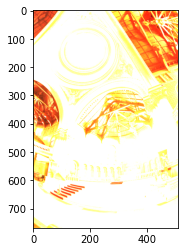

In [135]:
import matplotlib.pyplot as plt
import numpy as np

f = np.load('./memorial_hdr.npy')
plt.imshow(f)

`plt.imshow` Clipping input data to the valid range, so if the image's intensity is not from valid range, we should change the dtype of images.

In [3]:
print(f.dtype)

float32


Usually We can use uint8 (0 ~ 255) intensity. So I change the image $f$'s intensity to uint8

In [4]:
f = f.astype(np.uint8)
print(f.dtype)

uint8


Now We can see the right picture.

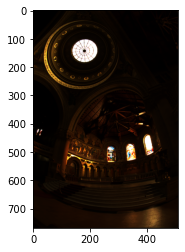

In [5]:
plt.imshow(f)

This picture is too dark, so we can use a **Log Transformation** which expan the values of dark pixels in an image while compressing the higher-level values.

In [6]:
def my_itf(f, c):
    g = c * np.log(f)
    g = g.astype(np.uint8)
    return g

<ipython-input-6-18a62ecc6b65>:2: RuntimeWarning: divide by zero encountered in log
  g = c * np.log(f)


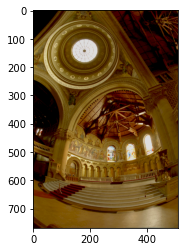

In [7]:
plt.imshow(my_itf(f,40))

## Problem 2

Download the file named "memorial_hdr.npy", load it, and try to display the image denoted as $f$

(a) Implement a histogram equalization function, as follows:

Apply histogram equalization in red, greed, and blue channels separately. Do not use any built-in functions such as equalizeHist()

In [8]:
f = np.load('./memorial_hdr.npy')
f = f.astype(np.uint8)

In [9]:
def histogram_eqaulization1(input_image):
    red = seperate_eqaulization1(input_image[:,:,0]).reshape(768,512,1)
    green = seperate_eqaulization1(input_image[:,:,1]).reshape(768,512,1)
    blue = seperate_eqaulization1(input_image[:,:,2]).reshape(768,512,1)
    return np.concatenate([red, green, blue],axis=2)

def seperate_eqaulization1(input_image):
    histo, bins = np.histogram(input_image.flatten(), 256, [0,256])
    cum_den_f = histo.cumsum()
    cdf_m = np.ma.masked_equal(cum_den_f, 0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[input_image]

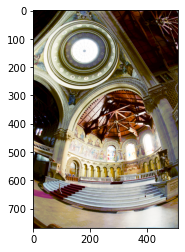

In [10]:
h = histogram_eqaulization1(f)
plt.imshow(h)

(b) Compute one histogram from all red, green, and blue channels. Apply the same histogram equalization to red, green, and blue channels using the function implemented in (b).

In [11]:
def histogram_eqaulization2(input_image):
    histo, bins = np.histogram(input_image.flatten(), 256, [0,256])
    cum_den_f = histo.cumsum()
    cdf_m = np.ma.masked_equal(cum_den_f, 0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[input_image]

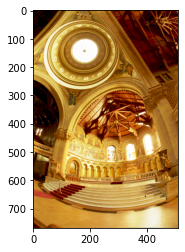

In [12]:
i = histogram_eqaulization2(f)
plt.imshow(i)

Explain why there is more color shift in $h$ compared to $i$.

This is because applying histogram equalization to each channel can provide more diverse intensities than applying it including all channels.

## Problem 3

Download "rubiks_cube.png". Some pixels are corrupted by noise.

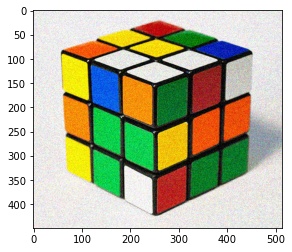

In [136]:
f = plt.imread('rubiks_cube.png')
plt.imshow(f)

(a) Design a function called "Bilateral Filter" as follows, Try with different variances. Explain the effect of sigmas.

In [137]:
def bilateral_filter(input_image, w, sigma_d, sigma_r):
    d = int(w/2)
    output_image = np.zeros_like(input_image)
    distances = np.arange(-d, d+1)**2
    g_distance = np.exp(-0.5 * (distances[:, None] + distances[None, :]) / sigma_d**2)
    for y in range(input_image.shape[0]):
        for x in range(input_image.shape[1]):
            i_min = max(y - d, 0)
            i_max = min(y + d + 1, input_image.shape[0])
            j_min = max(x - d, 0)
            j_max = min(x + d + 1, input_image.shape[1])
            for c in range(3): # Process each color channel
                I = input_image[i_min:i_max, j_min:j_max, c]
                dI = I - input_image[y, x, c]
                g_range = np.exp(-0.5 * (dI**2) / sigma_r**2)
                # Apply the Gaussian distance weights
                g = g_distance[(i_min-y+d):(i_max-y+d), (j_min-x+d):(j_max-x+d)] * g_range
                output_image[y, x, c] = np.sum(g * I) / np.sum(g)
    return np.clip(output_image, 0, 1)


We can use large sigma_d, it lead to relatively stronger smoothing

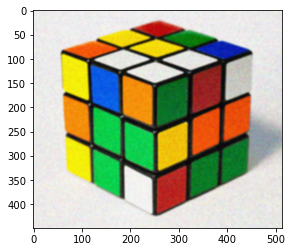

In [145]:
g = bilateral_filter(f, 5, 10, 1)
plt.imshow(g)

sigma_d controls the spatial extent of the kernel, Large sigma learding to stronger smoothing but with a higher risk of blurring edges.

We also can use large sigma_r, it can maintain sharpness of the edges 

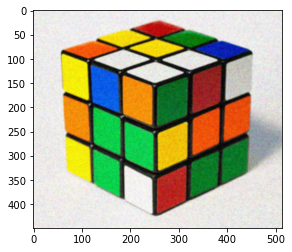

In [146]:
g = bilateral_filter(f, 5, 1, 10)
plt.imshow(g)

sigma_r determines how differences in pixel intensity influence the weighting. so Large sigma_r can lead to averaging across edges, potentially blurring important details.

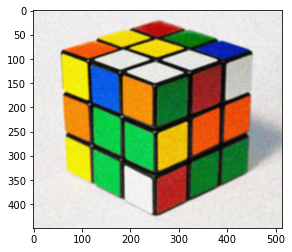

In [147]:
g = bilateral_filter(f, 5, 2, 2)
plt.imshow(g)

So we need to find appropriate range of simga_r and sigma_d

(b) Apply the same spatial Gaussian filter to the input image. Display $f,g$ from (a), and the Gaussian filtered image. Discuss the visual differences between the two filtered images.

### Bilateral Filter

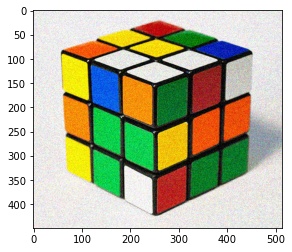

In [148]:
plt.imshow(f)

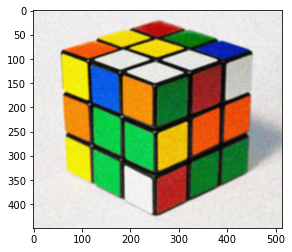

In [149]:
g = bilateral_filter(f, 5, 2, 2)
plt.imshow(g)

### Gaussian Filter

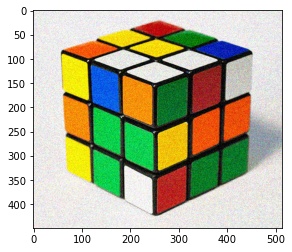

In [142]:
plt.imshow(f)

In [120]:
def gaussian_filter(image, kernel_size, sigma):
    k = kernel_size // 2
    x, y = np.mgrid[-k:k+1, -k:k+1]
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    output = np.zeros_like(image)
    padded_image = np.pad(image, [(k, k), (k, k), (0, 0)], mode='reflect')
    # Apply Gaussian filter to each channel
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                output[y, x, c] = np.sum(padded_image[y:y+kernel_size, x:x+kernel_size, c] * kernel)
    return output

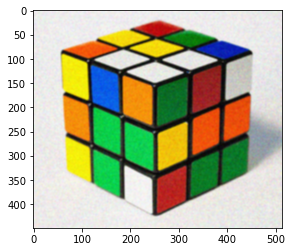

In [144]:
g = gaussian_filter(f, 5, 2)
plt.imshow(g)
plt.imshow(g)

We can see the difference between two filters, if sigma_d is same. 

There is little difference of sharpness of the edge between gaussian filter and bilateral filter.

Bilarteral filter has relatively more sharpness than gaussian filter.

And also, if we can change the parameter, we can easily control the sharpness of the picture or smoothness of the picture with bilateral filter. 
Because bilateral filter can control sigma_d(smoothness) and sigma_r(sharpness) but gaussian only using sigma(smoothness)